In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint

plt.style.use("ggplot")

# The TPKALK box model

## 1. Model formulation

Notebook implementing the box model for TPKALK outlined [here](https://niva.brage.unit.no/niva-xmlui/bitstream/handle/11250/208709/3412_200dpi.pdf?sequence=2&isAllowed=y#page=34). 

The model is illustrated below.

<img src="../docs/images/box_model.png" width="600">

Where:

 * $D$ is the dose of lime added (adjusted for Ca content i.e. the actual dose of Ca in mg/l)
 * $C_{inst}$ is the "immediate" increase in lake Ca concentration (in mg/l) due to **instantaneous dissolution**
 * $C_{bott} = D - C_{inst}$ is the amount of Ca (in mg/l) that sinks to the lake bottom, forming a layer that dissolves more slowly
 * $F_{slow}$ is the rate at which concentration increases (in mg/l/month) due to dissolution of the bottom layer
 * $C_{in}$ and $C_{out}$ are the inflow and outflow concentrations of Ca, respectively (both in mg/l)
 * $V$ is the lake volume in litres. The lake is assumed to be in **steady state** i.e. $V$ is constant
 * $Q$ is the discharge in l/month. To satisfy the steady state assumption, the inflow discharge must equal the outflow discharge
 * $M_{lake}$ is the mass of Ca dissolved in the lake water (in mg)
 * $C_{lake}$ is the Ca concentration in the lake, equal to $\frac{M_{lake}}{V}$. The lake is assumed to be **well mixed**, such that the outflow concentration, $C_{out}$, is equal to $C_{lake}$
 
Balancing sources and sinks of Ca gives

$$
\frac{dM_{lake}}{dt} = V \frac{dC_{lake}}{dt} = Q C_{in} - Q C_{lake} + V C_{inst} + V F_{slow}
$$

or

$$
\frac{dC_{lake}}{dt} = \frac{Q C_{in} - Q C_{lake}}{V} + C_{inst} + F_{slow}
$$

The lime that sinks to the bottom, $C_{bott}$, is assumed to dissolve quickly at first, then more slowly as time passes. TPKALK uses an exponential function to represent this slow dissolution effect

$$
F_{slow} = \frac{dC_{slow}}{dt} = C_{bott} K_L e^{-K_L t}
$$

The integral of the function $K_L exp(-K_L t)$ from zero to infinity is equal to 1. This functional form is chosen in order to conserve mass: the total amount of lime on the bottom of the lake is enough to increase the lake concentration by $C_{bott}$ mg/l. Between any two time points, the function for $F_{slow}$ can be integrated to give a number between 0 and 1 representing the proportion of $C_{bott}$ that dissolves within the period. For periods soon after the time when lime is added, this proportion will be large, and it decays over time. However, because the total area under the curve is equal to one, the total amount of lime that dissolves from the bottom layer can never be greater than $C_{bott}$.

The parameter $K_L$ (units $month^{-1}$) is the “deaktiveringskoeffisient”, a constant that controls how fast lime on the lake bottom dissolves. The plot below shows curves for $F_{slow}$ for various values of $K_L$ (for the case where $C_{bott} = 1$ i.e. the area under all three curves is one). The x-axis spans a time period of one month.

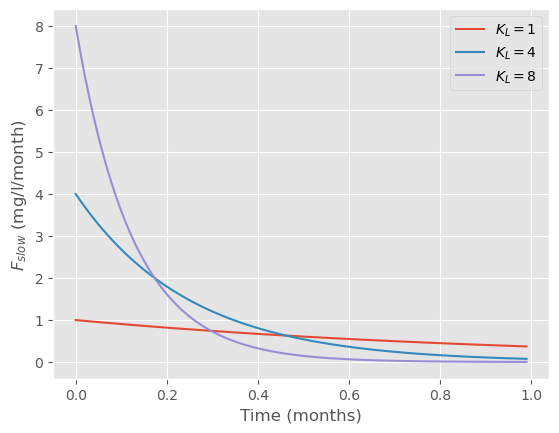

In [2]:
# Plot different values for K_L
fig = plt.figure()
KLs = [1, 4, 8]
xs = np.arange(0, 1, 0.01)
for KL in KLs:
    ys = KL * np.exp(-KL * xs)
    plt.plot(xs, ys, ls="-", label=f"$K_L = {KL}$")
plt.xlabel("Time (months)")
plt.ylabel("$F_{slow}$ (mg/l/month)")
plt.legend()

## 2. Model for a single time step (i.e. no discontinuous forcing)

### 2.1 Define model

In [3]:
def f(y, t, params):
    """Define the ODE system for the TPKALK box model.

    Args
        y:      List. [C_lake]. Current lake concentration of Ca in mg/l
        t:      Array. Time points at which to evaluate C_lake (in months)
        params: Tuple. (Q, V, C_in, C_bott, K_L).
                    Q is mean flow in litres/month
                    V is lake volume in litres
                    C_in in lake inflow concentration of Ca in mg/l
                    C_bott is the 'dose' of lime on the lake bottom in mg-Ca/l
                    K_L determines the rate of dissoltuion of lime on the bottom
                    of the lake (months^-1)

    Returns
        Array.
    """
    # Unpack incremental value for C_lake
    C_lake = y[0]

    # Unpack fixed params
    Q, V, C_in, C_bott, K_L = params

    # Model equations
    dCslow_dt = C_bott * K_L * np.exp(-K_L * t)
    dClake_dt = (Q * C_in - Q * C_lake) / V + dCslow_dt

    # Add results of equations to an array
    res = np.array([dClake_dt])

    return res

### 2.2. User input

In [4]:
# Initial conditions
C_lake0 = 1  # mg-Ca/l
C_in0 = 1  # mg-Ca/l
C_bott0 = 0  # mg-Ca/l

# Liming parameters
lime_dose = 10  # mg-lime/l
pct_ca = 38.5  # % Ca in lime by mass
od_fac = 1.5  # Overdosing factor
K_L = 1  # month^-1

# Lake characteristics
area = 1.14  # km2
mean_depth = 5.6  # m
mean_flow = 0.2  # m3/s

# Model setup
n_months = 12 # Number of months to simulate

### 2.3. Run model

array([<AxesSubplot:>], dtype=object)

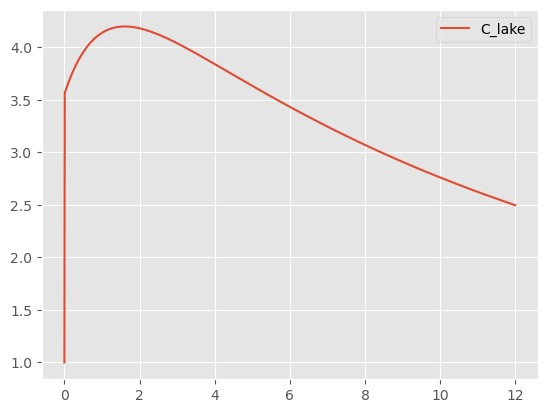

In [5]:
ca_dose = lime_dose * pct_ca / 100
C_inst = ca_dose / od_fac
C_bott = C_bott0 + ca_dose - C_inst
C_lake = C_lake0 + C_inst
V = 1000 * area * 1e6 * mean_depth  # Lake volume in litres
q = mean_flow * 1000 * 60 * 60 * 24 * 30 # Flow in litres/month

# Vector of initial conditions
y0 = [C_lake]

# Model parameters
params = [q, V, C_in0, C_bott, K_L]

# Solve
ti = np.arange(0, n_months, 0.01)
y = odeint(f, y0, ti, args=(params,))

# Build df from output
df = pd.DataFrame(data=y, columns=["C_lake"], index=ti)

# Add C_lake0 (before any lime added) to the very start of the series
df.loc[-0.01] = C_lake0
df.index = df.index + 0.01
df.sort_index(inplace=True) 

df.plot(subplots=True)

## 3. Model for multiple time steps (with discontinuous forcing)

**To do (if necessary)**. Should be easy - we just need to loop over the time steps and apply the model above.

In [6]:
# # Initial conditions
# C_lake0 = 0  # mg-Ca/l
# C_in0 = 0  # mg-Ca/l
# C_bott0 = 0  # mg-Ca/l

# # Liming parameters
# lime_month = 7
# lime_dose = 0  # mg-lime/l
# pct_ca = 38.5  # % by mass
# od_fac = 1.5
# K_L = 1

# # Lake characteristics
# area = 1.14  # km2
# mean_depth = 5.6  # m
# mean_flow = 0.2  # m3/s
# lake_type = "fjell"  # Determines discharge profile

# # Model setup
# n_years = 5  # Simulation length in years

In [7]:
# # Typical monthly flow relative to mean for different lake settings
# q_df = pd.read_excel("relative_discharge_by_month.xlsx", index_col=0)
# V = 1000 * area * 1e6 * mean_depth  # litres
# lime_series = np.zeros(shape=(12 * n_years))
# lime_series[lime_month - 1] = lime_dose
# months = list(range(1, 13)) * n_years